<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/TF_Hess_Visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing Hessian in Tensorflow

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

(x_train,y_train),_=tf.keras.datasets.mnist.load_data()
x_train = x_train/255
x_train = x_train - x_train.mean(0)
x_train = x_train.reshape(-1,28*28)
x_train = x_train.astype('float32')
y_train = y_train.astype('int32')

11493376/11490434 [==============================] - 0s 0us/step


In [2]:
## model

w = tf.Variable(tf.random.normal(shape=(28*28,10),stddev=0.1),trainable=True)
optimizer = tf.optimizers.SGD(0.01)

def logp(logits,y):
  return tf.gather(logits,y,batch_dims=1)-tf.reduce_logsumexp(logits,axis=1)

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    all_logits = tf.matmul(x,w) # (n_batch,n_class)
    loss = -logp(all_logits,y) # (n_batch,)
  gradients = tape.gradient(loss,[w])
  optimizer.apply_gradients(zip(gradients,[w]))

In [3]:
## datasets

tf_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
tf_data = tf_data.batch(32,drop_remainder=True)
tf_data = tf_data.cache()
tf_data = tf_data.prefetch(1)

In [4]:
## training loop

import time

w_start = np.random.normal(scale=0.1,size=(28*28,10))
w_start = np.zeros(shape=(28*28,10))

# tensorflow dataset

for _ in range(3):
  for x,y in tf_data:
    train_step(x,y)

# expect ~ 91.5% of accuracy fit with the linear model
print('accuracy', (x_train.dot(w.numpy()).argmax(1)==y_train).mean() )

accuracy 0.9138666666666667


In [5]:
## get the hessian and plot it !

x,y = x_train[:256],y_train[:256]

with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    all_logits = tf.matmul(x,w) # (n_batch,n_class)
    loss = -logp(all_logits,y) # (n_batch,)
    loss = tf.reduce_sum(loss) # (,)
    
  grads = inner_tape.gradient(loss, w)

h = outer_tape.jacobian(grads, w)

n_params = w.shape[0]*w.shape[1]
h_reshaped = tf.reshape(h,[n_params,n_params]).numpy()

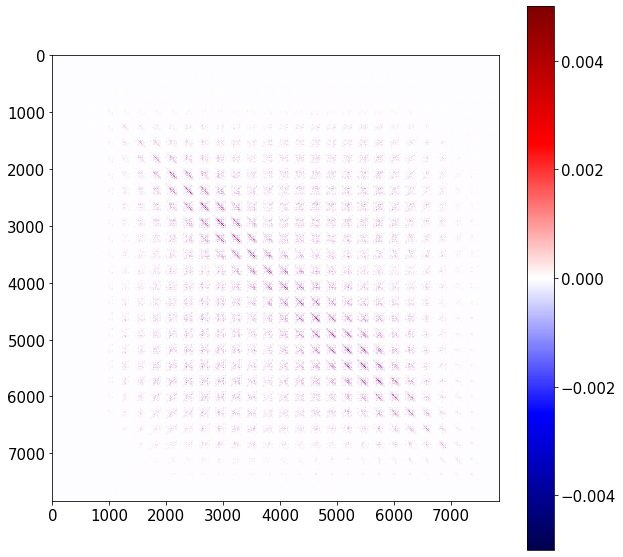

In [13]:
import matplotlib.colors as colors

lim = tf.reduce_max(abs(h))
plt.figure(figsize=(10,10))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.imshow(h_reshaped, vmin=-0.005,vmax= 0.005, cmap='seismic')
plt.colorbar()

In [7]:
print('diag sum',np.diag(h_reshaped).mean())
print('average row sum',h_reshaped.mean(0).mean())

diag sum 0.20781562
average row sum 8.246762e-11


In [8]:
h_reshaped.std(0).mean()

0.015417229